In [27]:
# import libraries
import math

import numpy as np

import scipy
from scipy.io import loadmat  # for loading matlab files

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV

In [28]:
# Data Preparation

# training data loading - input and output

x_train = loadmat('x_train.mat')
x_train = np.array(x_train['x_train'])
print(type(x_train),x_train.shape)

y_train = loadmat('y_train.mat')
y_train = np.array(y_train['y_train'])
print(type(y_train),y_train.shape)

# test data loading - input and ground truth output, predicted output is to be generated by GPR model

x_test = loadmat('x_test.mat')
x_test = np.array(x_test['x_test'])
# x_test = np.reshape(x_test[:,1],(-1,1)) # only the second column is extracted for simplicity
print(type(x_test),x_test.shape)

y_testtrue = loadmat('y_testtrue.mat')
y_testtrue = np.array(y_testtrue['y'])
# y_testtrue = np.reshape(y_testtrue[:,0],(-1,1))
print(type(y_testtrue),y_testtrue.shape)

<class 'numpy.ndarray'> (215, 2)
<class 'numpy.ndarray'> (215, 1)
<class 'numpy.ndarray'> (147, 2)
<class 'numpy.ndarray'> (147, 1)


In [29]:
# truncate data for limited resources
OFFSET = 0
NUM_TRAIN = 30
NUM_PRED = 10

# take the first NUM_TRAIN samples for training
x_train = x_train[OFFSET:NUM_TRAIN + OFFSET]
y_train = y_train[OFFSET:NUM_TRAIN + OFFSET]

# print the size of the training data
print('x_train size:',x_train.shape)
print('y_train size:',y_train.shape)

# take the first NUM_PRED samples for prediction
x_test = x_test[:NUM_PRED]
y_testtrue = y_testtrue[:NUM_PRED]

# print the size of the test data
print('x_test size:',x_test.shape)
print('y_testtrue size:',y_testtrue.shape)

x_train size: (30, 2)
y_train size: (30, 1)
x_test size: (10, 2)
y_testtrue size: (10, 1)


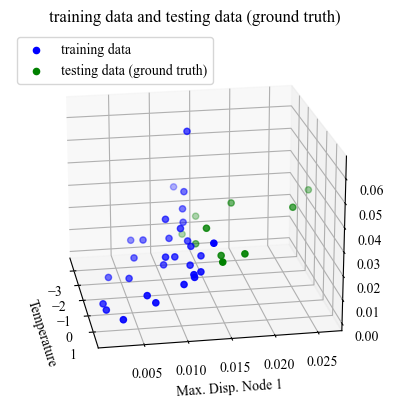

In [30]:
# visualize the data 

fig_dc = plt.figure()
ax_dc = fig_dc.add_subplot(111, projection = '3d')

# plot the data
ax_dc.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_dc.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'testing data (ground truth)')

# set the limits for the plots
# ax_dc.set_xlim(-3, 3)
# ax_dc.set_ylim(0, 0.03)
# ax_dc.set_zlim(0, 0.1)

# set the labels and titles for the plots
ax_dc.set_xlabel('Temperature')
ax_dc.set_ylabel('Max. Disp. Node 1')
ax_dc.set_zlabel('y')
ax_dc.set_title('training data and testing data (ground truth)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_dc.view_init(20, -10)

# Show the plot
plt.show()

GPR computation

In [31]:
# hyperparameters
RBF_Amplitude = 1
RBF_LengthScale = [5,0.2]
noise_lvl = 0.0004

# other parameters
RBF_Coef = 0.5

In [32]:
def gpr_kernel(PntA, PntB, RBF_Amplitude, RBF_LenScale, RBF_Coef):
    DIM_GPR_IN = len(PntA)
    AB_Diff = np.zeros(DIM_GPR_IN)
    
    # Calculate the difference between PntA and PntB
    K_Unit = 0
    for ind_t in range(DIM_GPR_IN):
        AB_Diff[ind_t] = PntA[ind_t] - PntB[ind_t]
        K_Unit += AB_Diff[ind_t] * AB_Diff[ind_t] / (RBF_LenScale[ind_t] * RBF_LenScale[ind_t])
    
    # Calculate the kernel function
    K_Unit = RBF_Amplitude * RBF_Amplitude * np.exp(-RBF_Coef * K_Unit)
    return K_Unit


In [33]:
# compute the kernel matrix Ktt, Kttn, Kpt, Kpt, Kpp

# Ktt
Ktt = np.zeros((NUM_TRAIN, NUM_TRAIN))
for ind_t in range(NUM_TRAIN):
    for ind_tt in range(NUM_TRAIN):
        Ktt[ind_t, ind_tt] = gpr_kernel(x_train[ind_t], x_train[ind_tt], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# Kttn - add noise to the diagonal of Ktt
Kttn = Ktt + noise_lvl * np.eye(NUM_TRAIN)


In [34]:

# Kpt
Kpt = np.zeros((NUM_PRED, NUM_TRAIN))
for ind_p in range(NUM_PRED):
    for ind_t in range(NUM_TRAIN):
        Kpt[ind_p, ind_t] = gpr_kernel(x_test[ind_p], x_train[ind_t], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# print the last 3 rows and colums of Kpt
print("Kpt")
print(Kpt[-3:, -3:])


Kpt
[[0.62210013 0.96995507 0.99859854]
 [0.65869785 0.98285165 0.993967  ]
 [0.6980583  0.99282667 0.98469108]]


In [35]:

# Ktp
Ktp = np.zeros((NUM_TRAIN, NUM_PRED))
for ind_t in range(NUM_TRAIN):
    for ind_p in range(NUM_PRED):
        Ktp[ind_t, ind_p] = gpr_kernel(x_train[ind_t], x_test[ind_p], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# print the last 3 rows and colums of Ktp
print("Ktp")
print(Ktp[-3:, -3:])


Ktp
[[0.62210013 0.65869785 0.6980583 ]
 [0.96995507 0.98285165 0.99282667]
 [0.99859854 0.993967   0.98469108]]


In [36]:

# Kpp
Kpp = np.zeros((NUM_PRED, NUM_PRED))

for ind_p in range(NUM_PRED):
    for ind_pp in range(NUM_PRED):
        Kpp[ind_p, ind_pp] = gpr_kernel(x_test[ind_p], x_test[ind_pp], RBF_Amplitude, RBF_LengthScale, RBF_Coef)
        
# print the last 3 rows and colums of Kpp
print("Kpp")
print(Kpp[-3:, -3:])


Kpp
[[1.         0.99810462 0.99188181]
 [0.99810462 1.         0.99780959]
 [0.99188181 0.99780959 1.        ]]


In [37]:

# Invert Kttn - IKttn
IKttn = np.linalg.inv(Kttn)

# print the last 3 rows and colums of IKttn
print("IKttn")
print(IKttn[-3:, -3:])


IKttn
[[ 272.53569806  -39.36847294   88.85690185]
 [ -39.36847294 2140.24884626  -27.60492025]
 [  88.85690185  -27.60492025 1564.97956851]]


In [38]:

# mean of y_testtrue - scalar
mean_y_testtrue = np.mean(y_train)

# print the mean of y_testtrue
print("mean_y_testtrue")
print(mean_y_testtrue)

mean_y_testtrue
0.01941912498078724


In [39]:
KptxIKttn = np.dot(Kpt, IKttn)

# print the last 3 rows and colums of KptxIKttn
print("KptxIKttn")
print(KptxIKttn[-3:, -3:])

KptxIKttn
[[-0.00387376  0.11268002  0.34801599]
 [ 0.02130462  0.12218301  0.19937204]
 [ 0.03076759  0.13274183  0.09502019]]


In [40]:
# y_testpred = Kpt * IKttn * (y_train - mean_y_train) + mean_y_testtrue

y_testpred = Kpt @ IKttn @ (y_train - mean_y_testtrue) + mean_y_testtrue

# print the all the values of y_testpred
print("y_testpred")
print(y_testpred)


y_testpred
[[0.02351508]
 [0.05943565]
 [0.02487223]
 [0.02959868]
 [0.04708248]
 [0.03462615]
 [0.02771585]
 [0.03218941]
 [0.02666651]
 [0.02371248]]


so far, the prediction values are good

In [41]:

# y_testpred_var = Kpp - Kpt * IKttn * Ktp

T2 = Kpt @ IKttn @ Ktp

# print the last 3 rows and colums of T2

print("T2:")
print(T2[-3:, -3:])


T2:
[[0.99981901 0.99798573 0.99180403]
 [0.99798573 0.99991116 0.99774131]
 [0.99180403 0.99774131 0.99993824]]


In [42]:

y_testpred_var = Kpp - Kpt @ IKttn @ Ktp

# print the last 3 rows and colums of y_testpred_var
print("y_testpred_var")
print(y_testpred_var[-3:, -3:])


y_testpred_var
[[1.80987311e-04 1.18895314e-04 7.77791980e-05]
 [1.18895313e-04 8.88397285e-05 6.82741703e-05]
 [7.77791977e-05 6.82741710e-05 6.17593974e-05]]


In [43]:

# y_testpred_std = np.sqrt(np.diag(y_testpred_var))

var_elem = np.diag(y_testpred_var)

y_testpred_std = np.sqrt(var_elem)

std_testpred = y_testpred_std


In [44]:

y_testpred = y_testpred.reshape(-1,1)

std_testpred = std_testpred.reshape(-1,1)

# print y_testpred 
print("y_testpred")
print(y_testpred)

# print std_testpred
print("std_testpred")
print(std_testpred)


y_testpred
[[0.02351508]
 [0.05943565]
 [0.02487223]
 [0.02959868]
 [0.04708248]
 [0.03462615]
 [0.02771585]
 [0.03218941]
 [0.02666651]
 [0.02371248]]
std_testpred
[[0.00720554]
 [0.0199066 ]
 [0.00584702]
 [0.00683262]
 [0.01824028]
 [0.01037377]
 [0.01203991]
 [0.01345315]
 [0.00942548]
 [0.00785871]]


In [45]:
y_testpred_ub = y_testpred + 2 * std_testpred


y_testpred_lb = y_testpred - 2 * std_testpred

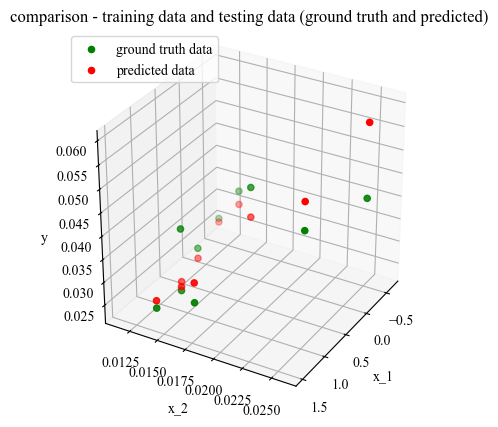

In [46]:
# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')

# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('x_1')
ax_gpr.set_ylabel('x_2')
ax_gpr.set_zlabel('y')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_gpr.view_init(30, 30)
# ax_gpr.view_init(90, 0)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

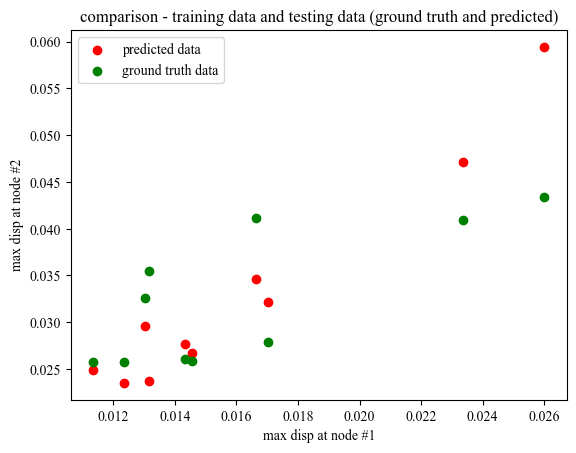

In [47]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'blue',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'green',label = 'ground truth data')

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

In [48]:
# check y_testpred_ub size
print(y_testpred_ub.shape)

(10, 1)


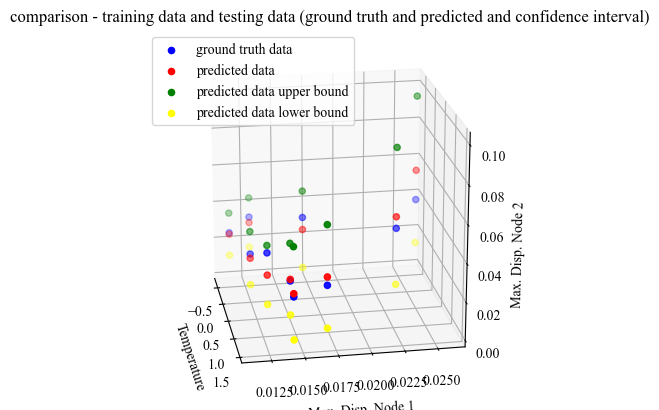

In [49]:
# visualize the data and confidence interval - 3D

# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'black',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'blue',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')


# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('Temperature')
ax_gpr.set_ylabel('Max. Disp. Node 1')
ax_gpr.set_zlabel('Max. Disp. Node 2')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# view
# ax_gpr.view_init(30, 30)
ax_gpr.view_init(20, -10)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

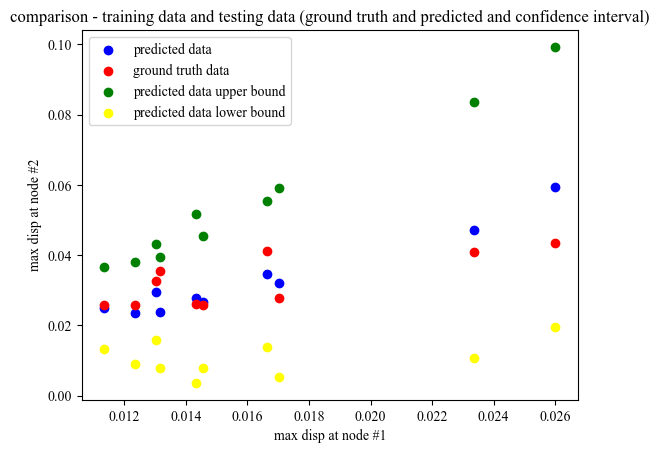

In [50]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'black',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'blue',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'red',label = 'ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')

# # fill the confidence interval
# fill_x = np.concatenate([x_test[:,1], x_test[:,1]],axis = 0)
# fill_y = np.concatenate([y_testpred_ub[:,0], y_testpred_lb[:,0]],axis = 0)
# fill_x, fill_y = zip(*sorted(zip(fill_x, fill_y)))
# tri = Delaunay(np.array([fill_x, fill_y]).T)
# plt.triplot(fill_x, fill_y, tri.simplices, color='blue', alpha=0.2)
# plt.fill(fill_x, fill_y, color='purple', alpha=0.2)

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()




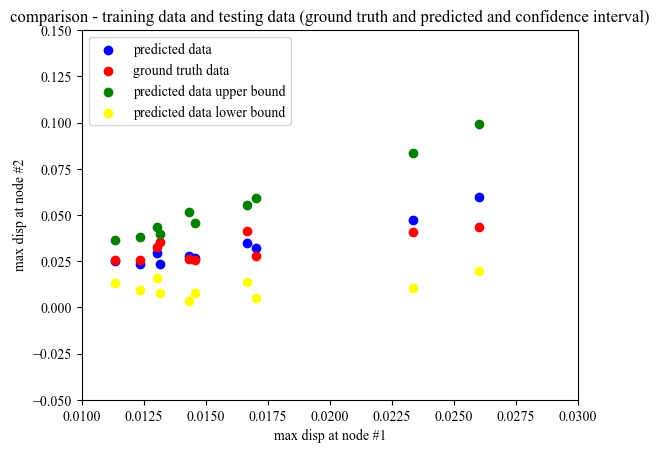

In [51]:
import matplotlib.pyplot as plt

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# 数据点的散点图
ax_gpr2d.scatter(x_test[:,1], y_testpred, c='blue', label='predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c='red', label='ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c='green', label='predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c='yellow', label='predicted data lower bound')

# 设置坐标轴范围
x_min = 0.01  # 用户定义的 x 轴最小值
x_max = 0.03  # 用户定义的 x 轴最大值
y_min = -0.05  # 用户定义的 y 轴最小值
y_max = 0.15  # 用户定义的 y 轴最大值
ax_gpr2d.set_xlim(x_min, x_max)
ax_gpr2d.set_ylim(y_min, y_max)

# 设置标签和标题
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# 添加图例
plt.legend(loc='best')

# 显示图像
plt.show()


upper limit:  0.022236619057889068
lower limit:  -0.022236619057889068


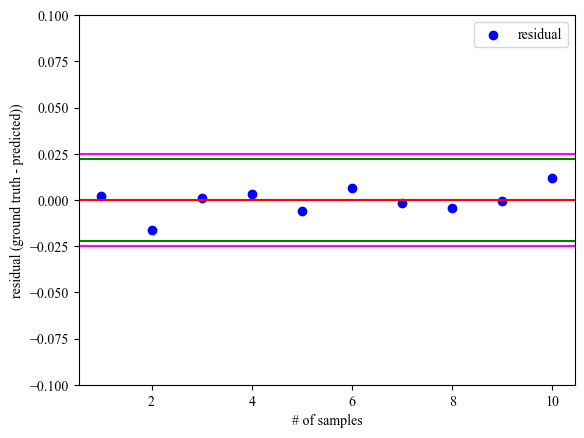

In [52]:
# SPC

y_res = y_testtrue - y_testpred

# visualize the residual - 2D
fig_spc2d = plt.figure()
ax_spc2d = fig_spc2d.add_subplot(111)

SampleNumber = np.linspace(1,len(y_res),len(y_res))

ax_spc2d.scatter(SampleNumber, y_res, c = 'blue',label = 'residual')

# set the labels and titles for the plots
ax_spc2d.set_xlabel('# of samples')
ax_spc2d.set_ylabel('residual (ground truth - predicted))')

# set the limits for the plots

# xmin_res = min(x_test[:,1])
# xmax_res = max(x_test[:,1])
ymin_res = min(y_res)
ymax_res = max(y_res)
ymark = max(abs(ymin_res), abs(ymax_res))

# ax_spc2d.set_xlim(-1.1*xmin_res, 1.1*xmax_res)
# ax_spc2d.set_ylim(-3*ymark, 3*ymark)
ax_spc2d.set_ylim(-0.1, 0.1)


# 0 line
plt.axhline(0, color='red')  # Draw the line at y = 0

# control limit
# upper_limit = max(2 * np.mean(std_testpred),max(y_res))
# lower_limit = min(2 * np.mean(std_testpred),min(y_res))

upper_limit = 2 * np.mean(std_testpred)
lower_limit = -2 * np.mean(std_testpred)
plt.axhline(upper_limit, color='green') # Draw the line at y = upper_limit
plt.axhline(lower_limit, color='green') # Draw the line at y = lower_limit

print('upper limit: ', upper_limit)
print('lower limit: ', lower_limit)


# standard deviation from the training data
std_train = np.std(y_train)
tul = 2.0 * std_train
tll = -2.0 * std_train
plt.axhline(tul, color='magenta') # Draw the line at y = upper_limit
plt.axhline(tll, color='magenta') # Draw the line at y = lower_limit

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

